In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import pandas as pd
import sklearn
import seaborn as sns
import graphviz
import copy
import sklearn.model_selection as skm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import (DecisionTreeClassifier as DTC,
                        DecisionTreeRegressor as DTR,
                        plot_tree)
from sklearn import tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,log_loss
from graphviz import Source
from sklearn.tree import export_graphviz
from sklearn.ensemble import (BaggingRegressor, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier as SklearnAdaBoostClassifier)
from scipy.stats import (randint, mode)
from sklearn.inspection import permutation_importance
from math import log

In [ ]:
df = pd.read_csv(r'D:\Downloads\Housing.csv')

In [ ]:
df.head()

price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished

In [ ]:
df.isna().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

In [ ]:
X=np.array(df[['area','bedrooms','bathrooms','stories']])
y=np.array(df['price'])

In [ ]:
feature_names = ['area','bedrooms','bathrooms','stories']
target_names=['price']

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42)

In [ ]:
rgt=DTR(max_depth=15,random_state=42)
rgt.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=15, random_state=42)

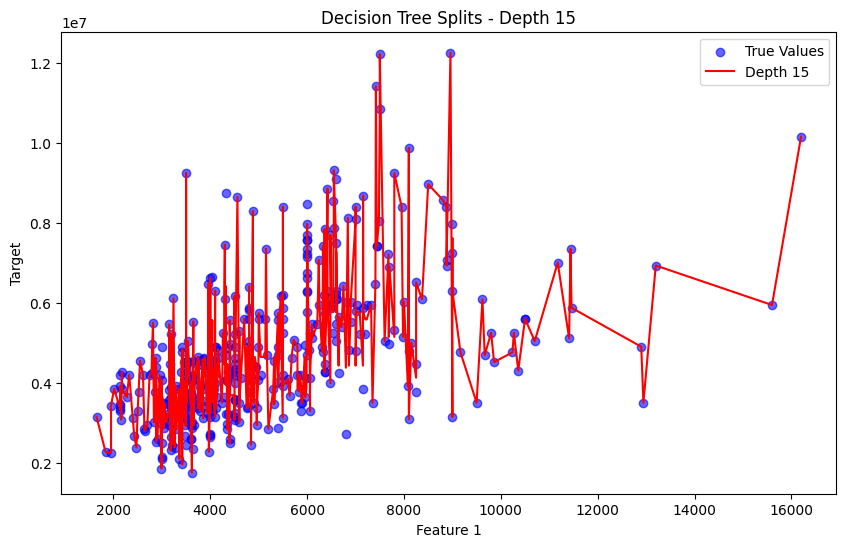

In [ ]:
from matplotlib.animation import FuncAnimation
fig, ax = plt.subplots(figsize=(10, 6))
def animate_tree_splits(tree, X, y):
    sorted_idx = np.argsort(X[:, 0])
    X_sorted, y_sorted = X[sorted_idx], y[sorted_idx]

    # Tạo hàm cập nhật cho animation
    def update(depth):
        # Tạo cây hồi quy với độ sâu tương ứng
        partial_tree = DTR(max_depth=depth, random_state=42)
        partial_tree.fit(X, y)
        predictions = partial_tree.predict(X_sorted)

        # Vẽ biểu đồ
        ax.clear()
        ax.scatter(X_sorted[:, 0], y_sorted, color='blue', label='True Values', alpha=0.6)
        ax.plot(X_sorted[:, 0], predictions, color='red', label=f'Depth {depth}')
        ax.set_title(f'Decision Tree Splits - Depth {depth}')
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Target')
        ax.legend()

    # Số lượng khung hình tương ứng với độ sâu tối đa của cây
    anim = FuncAnimation(fig, update, frames=range(1, tree.max_depth + 1), repeat=False, interval=1000)
    return anim

# Gọi hàm tạo animation
animation = animate_tree_splits(rgt, X_train, y_train)

# Lưu animation dưới dạng GIF
animation.save("tree_splits_animation.gif", writer="pillow")

# Trực quan hóa cây đầy đủ
plt.figure(figsize=(15, 10))
plot_tree(rgt, feature_names=['area', 'bedrooms', 'bathrooms', 'stories'], filled=True)
plt.show()

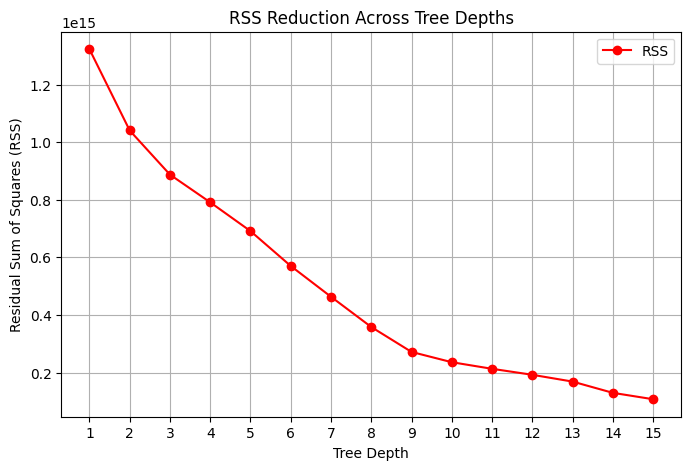

In [ ]:
# Hàm tính RSS
def compute_rss(y_true, y_pred):
    residuals = y_true - y_pred
    rss = np.sum(residuals ** 2)
    return rss

# Lưu giá trị RSS qua từng độ sâu
rss_values = []

# Tính RSS cho từng mức độ sâu
for depth in range(1, rgt.max_depth + 1):
    partial_tree = DTR(max_depth=depth, random_state=42)
    partial_tree.fit(X, y)
    predictions = partial_tree.predict(X)
    rss = compute_rss(y, predictions)
    rss_values.append(rss)

# Trực quan hóa RSS qua từng độ sâu
plt.figure(figsize=(8, 5))
plt.plot(range(1, rgt.max_depth + 1), rss_values, marker='o', color='red', label='RSS')
plt.title('RSS Reduction Across Tree Depths')
plt.xlabel('Tree Depth')
plt.ylabel('Residual Sum of Squares (RSS)')
plt.xticks(range(1, rgt.max_depth + 1))
plt.grid()
plt.legend()
plt.show()


In [ ]:
export_graphviz(rgt,out_file="data.dot",feature_names=feature_names,class_names=target_names,impurity=False,filled=True,rounded=True)
Source.from_file('data.dot')

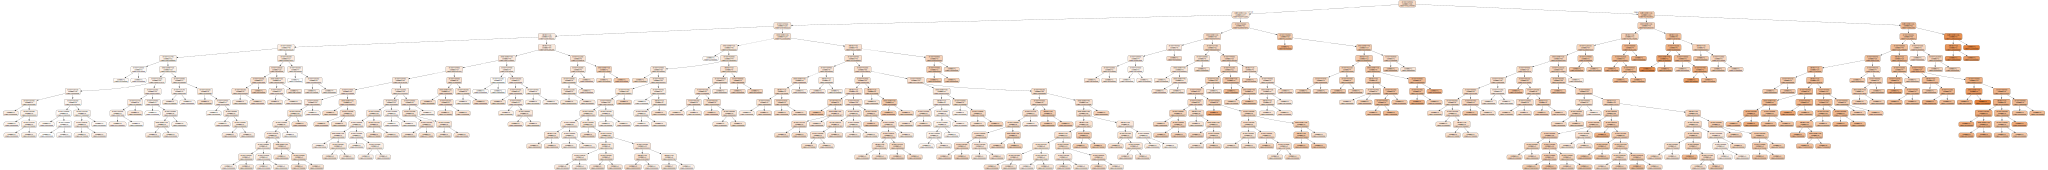

In [ ]:
export_graphviz(rgt,out_file="data2.dot",feature_names=feature_names,class_names=target_names,impurity=False,filled=True,rounded=True)
Source.from_file('data2.dot')

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_train_pred = rgt.predict(X_train)
y_test_pred = rgt.predict(X_test)
print(f"Train MAE: {mean_absolute_error(y_train, y_train_pred):.2f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_test_pred):.2f}")

print(f"Train MSE: {mean_squared_error(y_train, y_train_pred):.2f}")
print(f"Test MSE: {mean_squared_error(y_test, y_test_pred):.2f}")

print(f"Train R²: {r2_score(y_train, y_train_pred):.2f}")
print(f"Test R²: {r2_score(y_test, y_test_pred):.2f}")


Train MAE: 154561.74
Test MAE: 1329519.53
Train MSE: 147850465777.26
Test MSE: 4034462040807.54
Train R²: 0.95
Test R²: 0.12


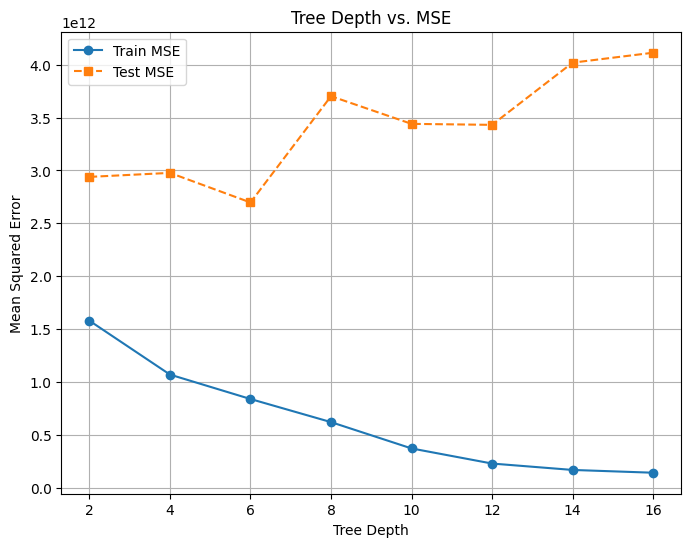

In [ ]:
# Initialize lists to store MSE for train and test sets
depths = [2, 4, 6, 8, 10, 12, 14, 16]
mse_train = []
mse_test = []

# Loop through different depths to evaluate the model
for max_depth in depths:
    rgt = DTR(max_depth=max_depth, random_state=42)  # Decision Tree Regressor
    rgt.fit(X_train, y_train)  # Fit the model on training data

    # Predict on training and test data
    y_train_pred = rgt.predict(X_train)
    y_test_pred = rgt.predict(X_test)

    # Compute Mean Squared Errors
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    # Append MSE values to their respective lists
    mse_train.append(train_mse)
    mse_test.append(test_mse)

# Plotting the MSE against tree depth
plt.figure(figsize=(8, 6))
plt.plot(depths, mse_train, marker='o', label='Train MSE', linestyle='-')
plt.plot(depths, mse_test, marker='s', label='Test MSE', linestyle='--')
plt.xlabel('Tree Depth')
plt.ylabel('Mean Squared Error')
plt.title('Tree Depth vs. MSE')
plt.legend()
plt.grid()
plt.show()


**Classification tree**


In [ ]:
df=pd.read_csv(r'/content/cleaned_merged_heart_dataset.csv')

In [ ]:
df.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalachh  exang  oldpeak  \
0   63    1   3       145   233    1        0       150      0      2.3   
1   37    1   2       130   250    0        1       187      0      3.5   
2   41    0   1       130   204    0        0       172      0      1.4   
3   56    1   1       120   236    0        1       178      0      0.8   
4   57    0   0       120   354    0        1       163      1      0.6   

   slope  ca  thal  target  
0      0   0     1       1  
1      0   0     2       1  
2      2   0     2       1  
3      2   0     2       1  
4      2   0     2       1

from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['age'].plot(kind='hist', bins=20, title='age')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['sex'].plot(kind='hist', bins=20, title='sex')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['cp'].plot(kind='hist', bins=20, title='cp')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='age', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='age', y='sex', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='sex', y='cp', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='cp', y='trestbps', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['age']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('age')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['sex']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('sex')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['cp']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('cp')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['trestbps']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('trestbps')

from matplotlib import pyplot as plt
_df_12['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['age'].plot(kind='line', figsize=(8, 4), title='age')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['sex'].plot(kind='line', figsize=(8, 4), title='sex')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['cp'].plot(kind='line', figsize=(8, 4), title='cp')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalachh    0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [ ]:
X=df.drop('target',axis=1)
y=df['target']

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(X,y,random_state=42)
print(x_train.shape)
print(x_test.shape)

(1416, 13)
(472, 13)


In [ ]:
clf = tree.DecisionTreeClassifier(random_state=42)
clf.fit(x_train,y_train)
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)
accuracy_score(y_test , y_test_pred)

0.9427966101694916

In [ ]:
depths = [2, 4, 6, 8, 10, 12, 14, 16]
accuracy_train = []
accuracy_test = []

# Loop through different depths to evaluate the model
for max_depth in depths:
    dtc = DTC(max_depth=max_depth, random_state=42)  # Decision Tree Classifier
    dtc.fit(x_train, y_train)  # Fit the model on training data

    # Predict on training and test data
    y_train_pred = dtc.predict(x_train)
    y_test_pred = dtc.predict(x_test)

    # Compute Accuracy Scores
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Append accuracy values to their respective lists
    accuracy_train.append(train_accuracy)
    accuracy_test.append(test_accuracy)

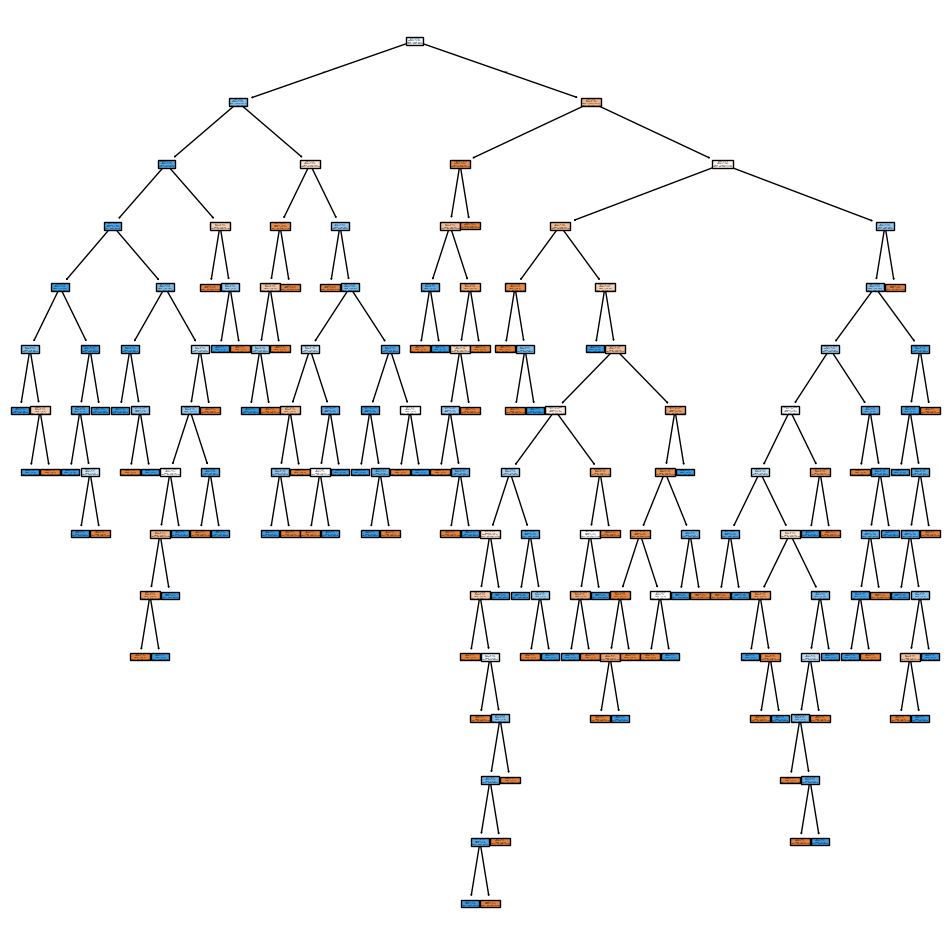

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
classes = ['Not heart disease', 'Heart disease']
plot_tree(clf,
          feature_names=X.columns,
          class_names=classes,
          ax=ax,
          filled=True)
plt.savefig("decision_tree_plot2.png", format="png", bbox_inches='tight')
plt.show()

In [ ]:
def plot_confusionmatrix(y_train_pred,y_train,dom):
    print(f'{dom} Confusion matrix')
    cf = confusion_matrix(y_train_pred,y_train)
    sns.heatmap(cf,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()

Train score 1.0
Test score 0.9427966101694916
Train Confusion matrix


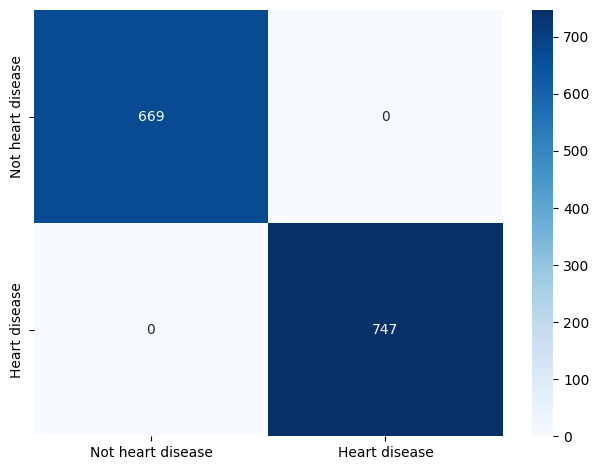

Test Confusion matrix


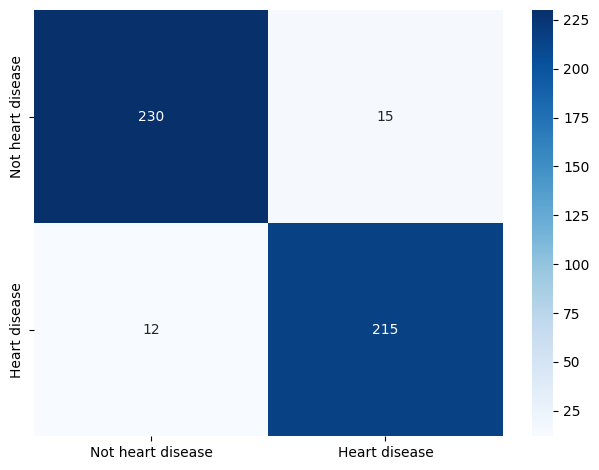

In [ ]:
print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

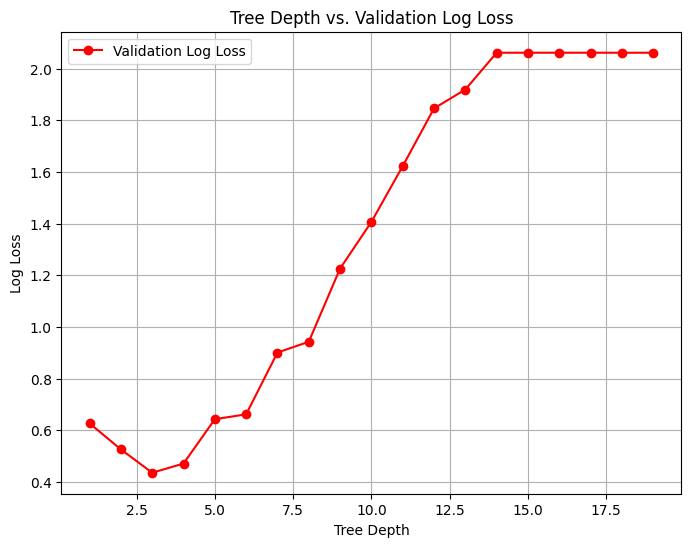

In [ ]:
depths = range(1, 20)
log_losses = []

# Loop over different tree depths
for depth in depths:
    clf = tree.DecisionTreeClassifier(max_depth=depth, random_state=42)
    # Train on the training split
    clf.fit(x_train, y_train)
    # Predict probabilities on the validation set
    y_prob = clf.predict_proba(x_test)
    # Compute log loss
    loss = log_loss(y_test, y_prob)
    log_losses.append(loss)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(depths, log_losses, label='Validation Log Loss', marker='o', color='r')
plt.xlabel('Tree Depth')
plt.ylabel('Log Loss')
plt.title('Tree Depth vs. Validation Log Loss')
plt.legend()
plt.grid()
plt.show()

**Pre-pruning**

In [ ]:
params = {'max_depth': [1,2,3,4,6,8,10,12],
         'min_samples_split': [2,3,4],
         'min_samples_leaf': [1,2]}

clf = tree.DecisionTreeClassifier(random_state=42)
gcv = GridSearchCV(estimator=clf,param_grid=params)
gcv.fit(x_train,y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [1, 2, 3, 4, 6, 8, 10, 12],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3, 4]})

Train score 0.9978813559322034
Test score 0.9427966101694916
Train Confusion matrix


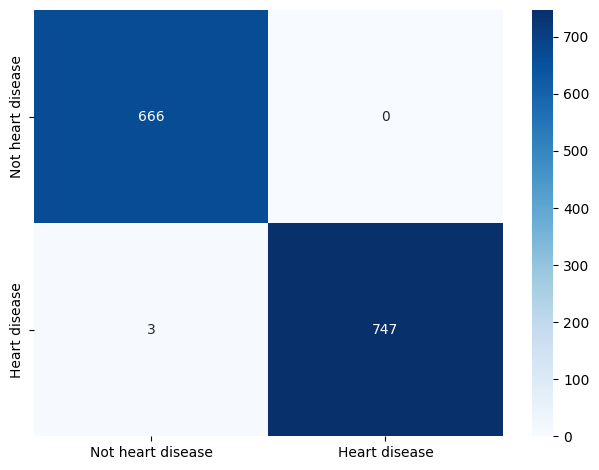

Test Confusion matrix


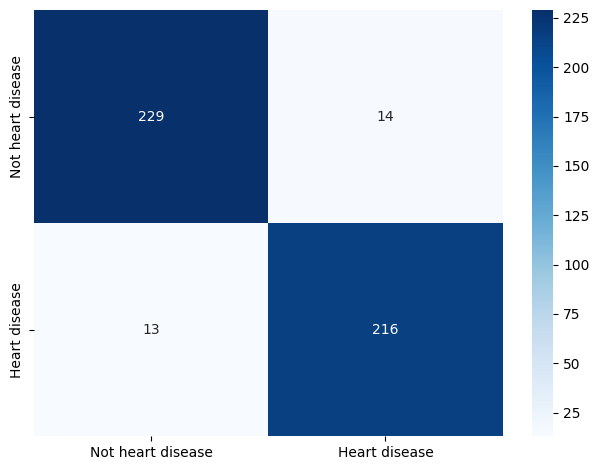

In [ ]:
model = gcv.best_estimator_
model.fit(x_train,y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

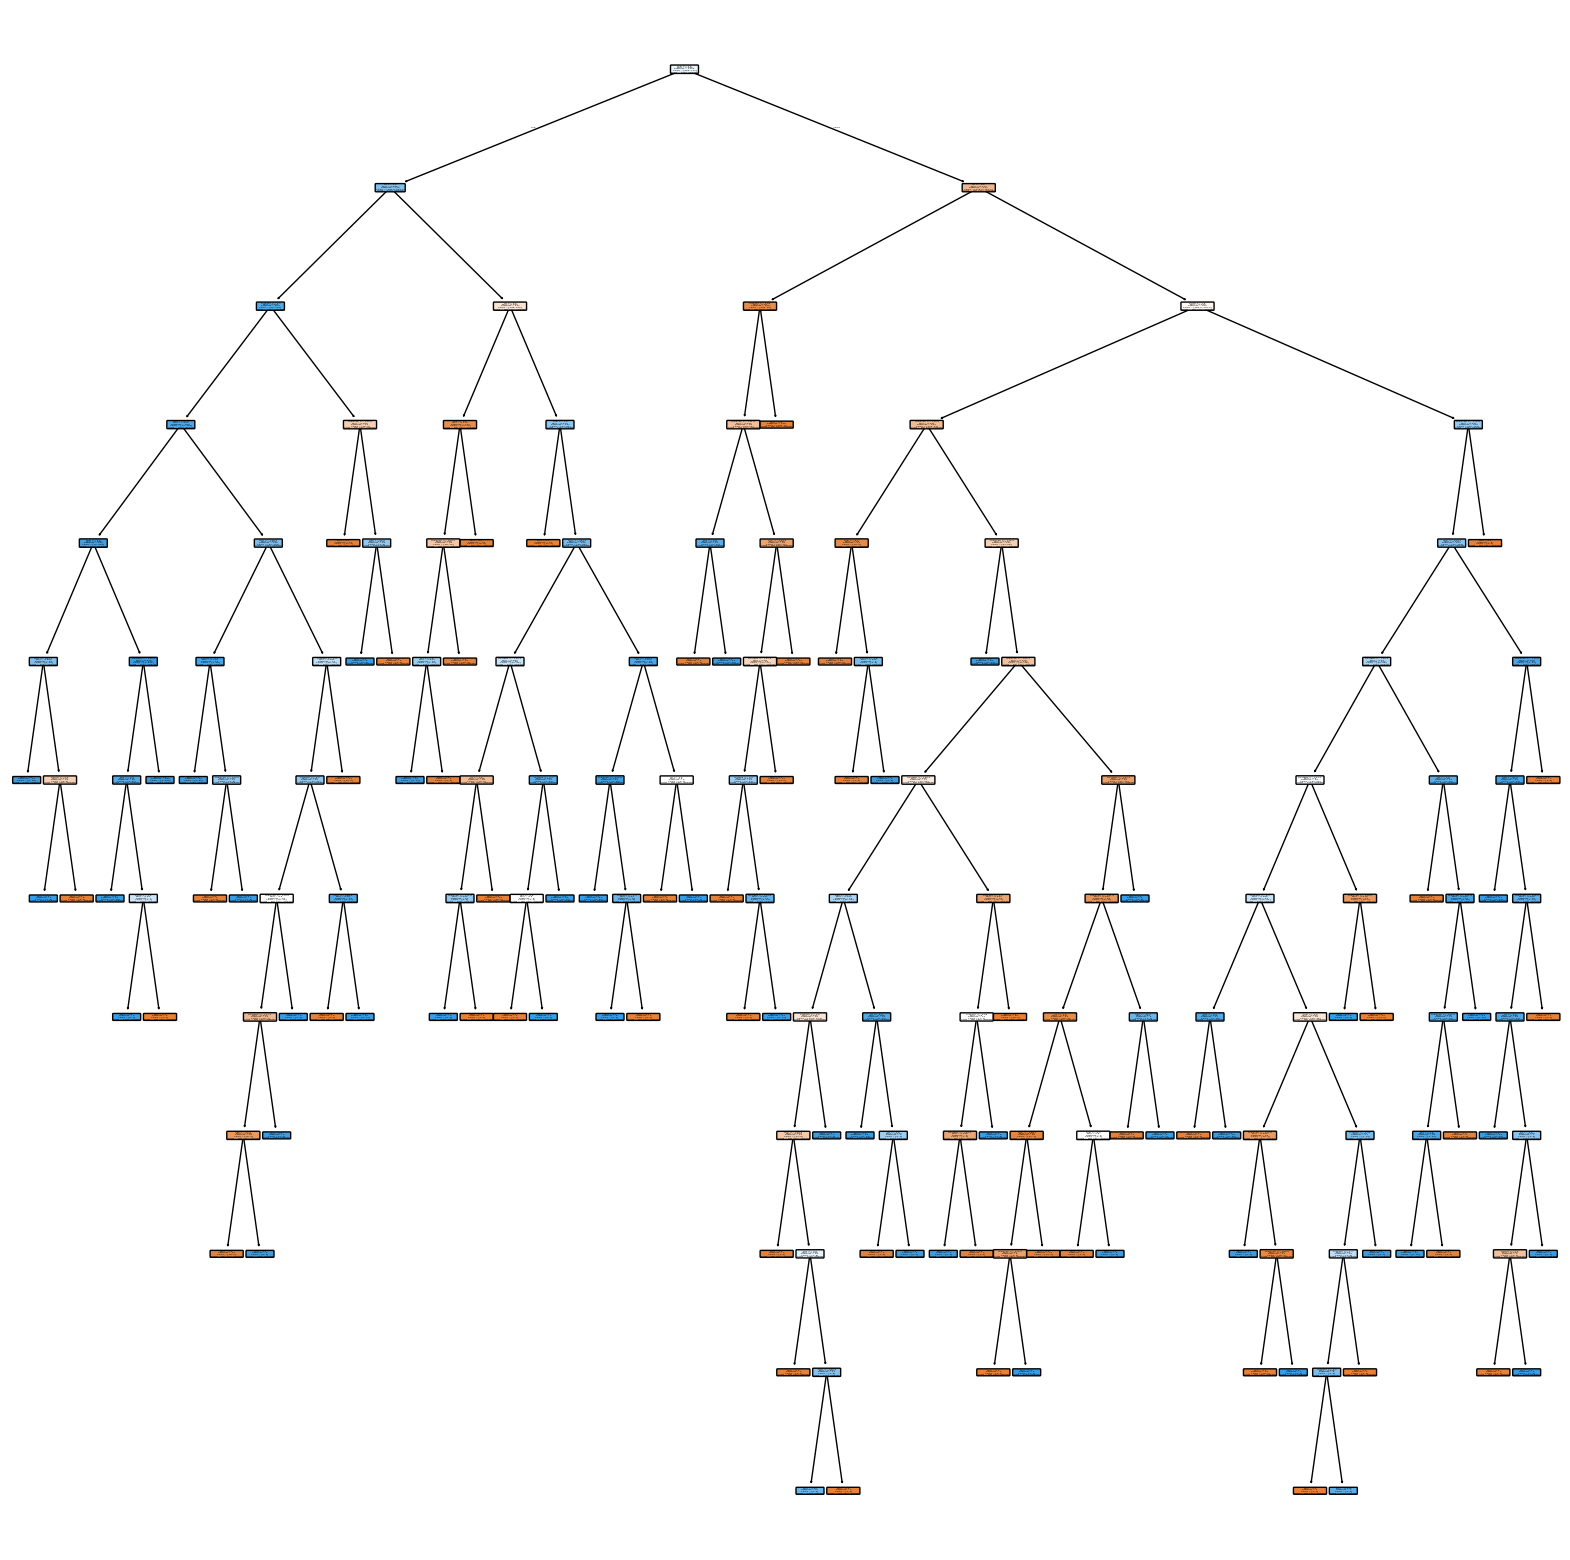

In [ ]:
plt.figure(figsize=(20,20))
features = df.columns
classes = ['Not heart disease','heart disease']
tree.plot_tree(model,feature_names=features,class_names=classes,filled=True,rounded=True)
plt.savefig('decision_tree.png', dpi=300, bbox_inches='tight')
plt.show()

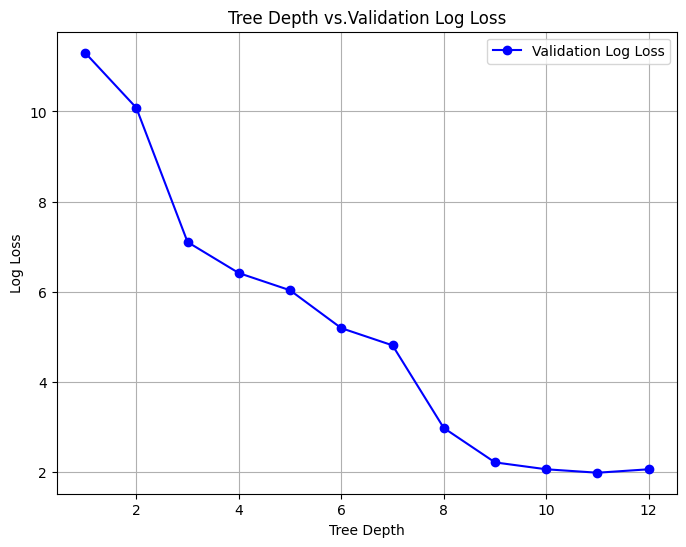

In [ ]:
depths = range(1, gcv.best_estimator_.max_depth + 1)
log_losses = []
for depth in depths:
    # Create a new model with the current max_depth
    model = tree.DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(x_train, y_train)
    # Compute accuracy on the validation set
    y_pred = model.predict(x_test)
    acc = log_loss(y_test, y_pred)
    log_losses.append(acc)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(depths, log_losses, label='Validation Log Loss', marker='o', color='b')
plt.xlabel('Tree Depth')
plt.ylabel('Log Loss')
plt.title('Tree Depth vs.Validation Log Loss')
plt.legend()
plt.grid()
plt.show()

**Post-pruning**

In [ ]:
ccp_path = clf.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = ccp_path.ccp_alphas, ccp_path.impurities
ccp_alphas

array([0.        , 0.0006915 , 0.00078968, 0.00089072, 0.00102722,
       0.00105932, 0.00105932, 0.00110086, 0.00112994, 0.00119914,
       0.00126375, 0.00132935, 0.00136687, 0.00139893, 0.00187297,
       0.00192411, 0.00219711, 0.0022389 , 0.00235405, 0.00240636,
       0.00242131, 0.00249252, 0.00250722, 0.0026455 , 0.00274639,
       0.00284626, 0.00288234, 0.00315303, 0.00329567, 0.00340379,
       0.00340614, 0.00343896, 0.00361485, 0.00381356, 0.00391134,
       0.00391134, 0.00396035, 0.00401855, 0.00403357, 0.0042554 ,
       0.00425958, 0.00446183, 0.00471457, 0.00513541, 0.00520432,
       0.00559159, 0.0056567 , 0.00619217, 0.00670076, 0.00908358,
       0.00912137, 0.00918303, 0.01699717, 0.03052148, 0.03777346,
       0.04521332, 0.09985287])

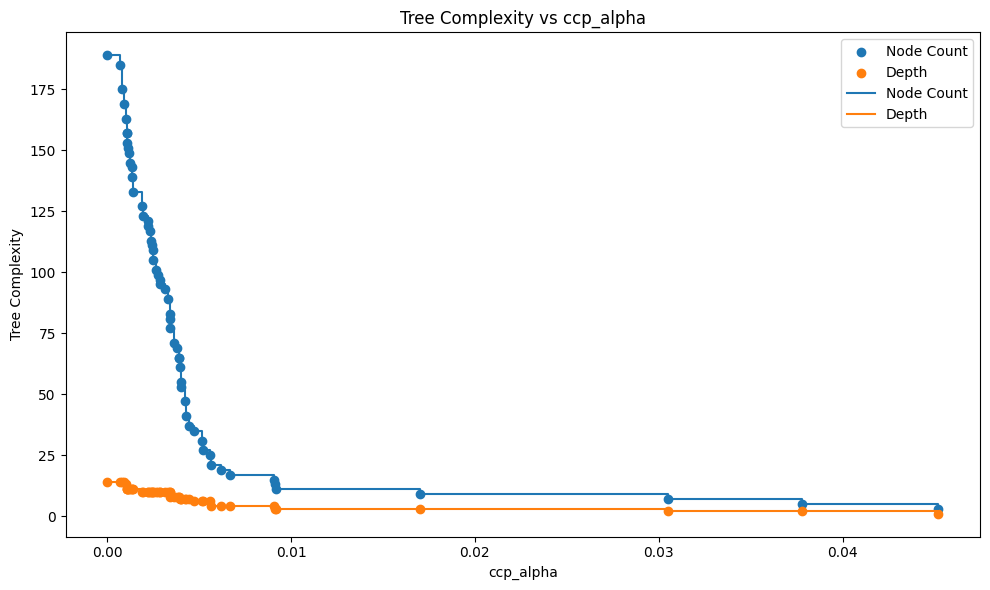

In [ ]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(x_train, y_train)
    clfs.append(clf)
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]

plt.figure(figsize=(10, 6))
plt.scatter(ccp_alphas, node_counts, label='Node Count')
plt.scatter(ccp_alphas, depth, label='Depth')
plt.plot(ccp_alphas, node_counts, label='Node Count', drawstyle="steps-post")
plt.plot(ccp_alphas, depth, label='Depth', drawstyle="steps-post")
plt.xlabel('ccp_alpha')
plt.ylabel('Tree Complexity')
plt.title('Tree Complexity vs ccp_alpha')
plt.legend()  # Ensure the legend is created
plt.tight_layout()  # Adjust the layout to make space for all elements
plt.savefig("Tree_Complexity_vs_ccp_alpha.png", format="png", bbox_inches='tight')  # Save with tight bounding box
plt.show()


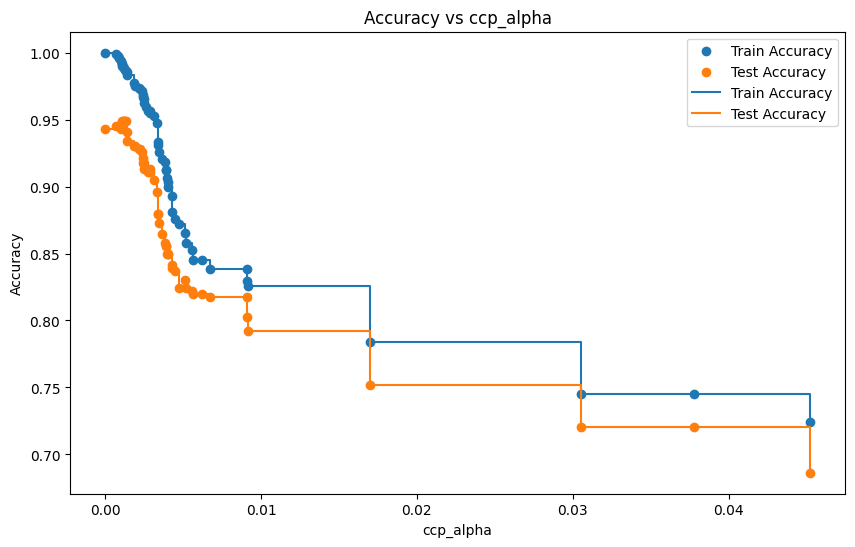

In [ ]:
train_acc = []
test_acc = []
for clf in clfs:
    train_acc.append(accuracy_score(y_train, clf.predict(x_train)))
    test_acc.append(accuracy_score(y_test, clf.predict(x_test)))

plt.figure(figsize=(10, 6))
plt.scatter(ccp_alphas, train_acc, label='Train Accuracy')
plt.scatter(ccp_alphas, test_acc, label='Test Accuracy')
plt.plot(ccp_alphas, train_acc, label='Train Accuracy', drawstyle="steps-post")
plt.plot(ccp_alphas, test_acc, label='Test Accuracy', drawstyle="steps-post")
plt.xlabel('ccp_alpha')
plt.ylabel('Accuracy')
plt.title('Accuracy vs ccp_alpha')
plt.legend()
plt.savefig("Accuracy_vs_ccp_alpha.png", format="png")
plt.show()

In [ ]:
grid = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42),
    param_grid={'ccp_alpha': ccp_alphas},
    refit=True,
    cv=None,
    scoring='accuracy'
)

grid.fit(x_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'ccp_alpha': array([0.        , 0.0006915 , 0.00078968, 0.00089072, 0.00102722,
       0.00105932, 0.00105932, 0.00110086, 0.00112994, 0.00119914,
       0.00126375, 0.00132935, 0.00136687, 0.00139893, 0.00187297,
       0.00192411, 0.00219711, 0.0022389 , 0.00235405, 0.00240636,
       0.00242131, 0.00249252, 0.00250722, 0.0026455 , 0.0...
       0.00284626, 0.00288234, 0.00315303, 0.00329567, 0.00340379,
       0.00340614, 0.00343896, 0.00361485, 0.00381356, 0.00391134,
       0.00391134, 0.00396035, 0.00401855, 0.00403357, 0.0042554 ,
       0.00425958, 0.00446183, 0.00471457, 0.00513541, 0.00520432,
       0.00559159, 0.0056567 , 0.00619217, 0.00670076, 0.00908358,
       0.00912137, 0.00918303, 0.01699717, 0.03052148, 0.03777346,
       0.04521332])},
             scoring='accuracy')

In [ ]:
best_alpha = grid.best_params_['ccp_alpha']
best_score = grid.best_score_
best_tree = grid.best_estimator_

print(f"Best ccp_alpha: {best_alpha}")
print(f"Best validation accuracy: {best_score:.4f}")

train_acc=accuracy_score(y_train,best_tree.predict(x_train))
test_accuracy = accuracy_score(y_test, best_tree.predict(x_test))
print(f"Train set accuracy: {train_acc:.4f}")
print(f"Test set accuracy: {test_accuracy:.4f}")

Best ccp_alpha: 0.0011299435028248586
Best validation accuracy: 0.9527
Train set accuracy: 0.9894
Test set accuracy: 0.9492


Train score 0.989406779661017
Test score 0.9491525423728814
Train Confusion matrix


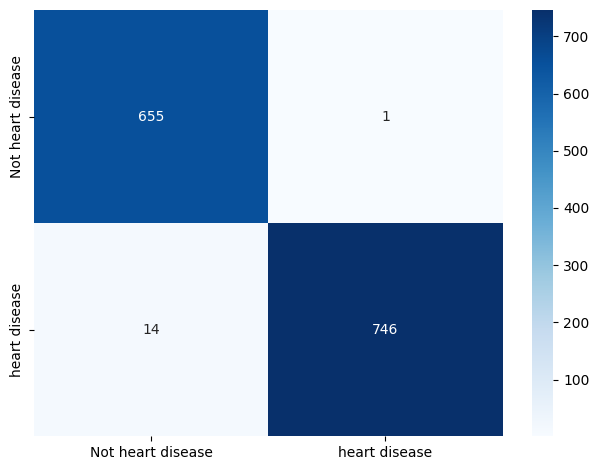

Test Confusion matrix


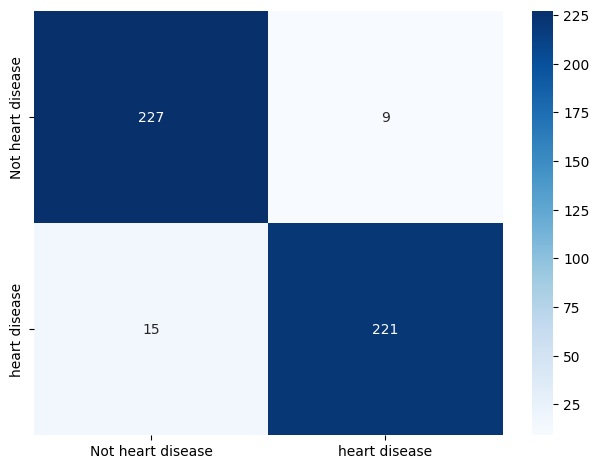

In [ ]:
clf_ = tree.DecisionTreeClassifier(random_state=42,ccp_alpha=best_alpha)
clf_.fit(x_train,y_train)
y_train_pred = clf_.predict(x_train)
y_test_pred = clf_.predict(x_test)

print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

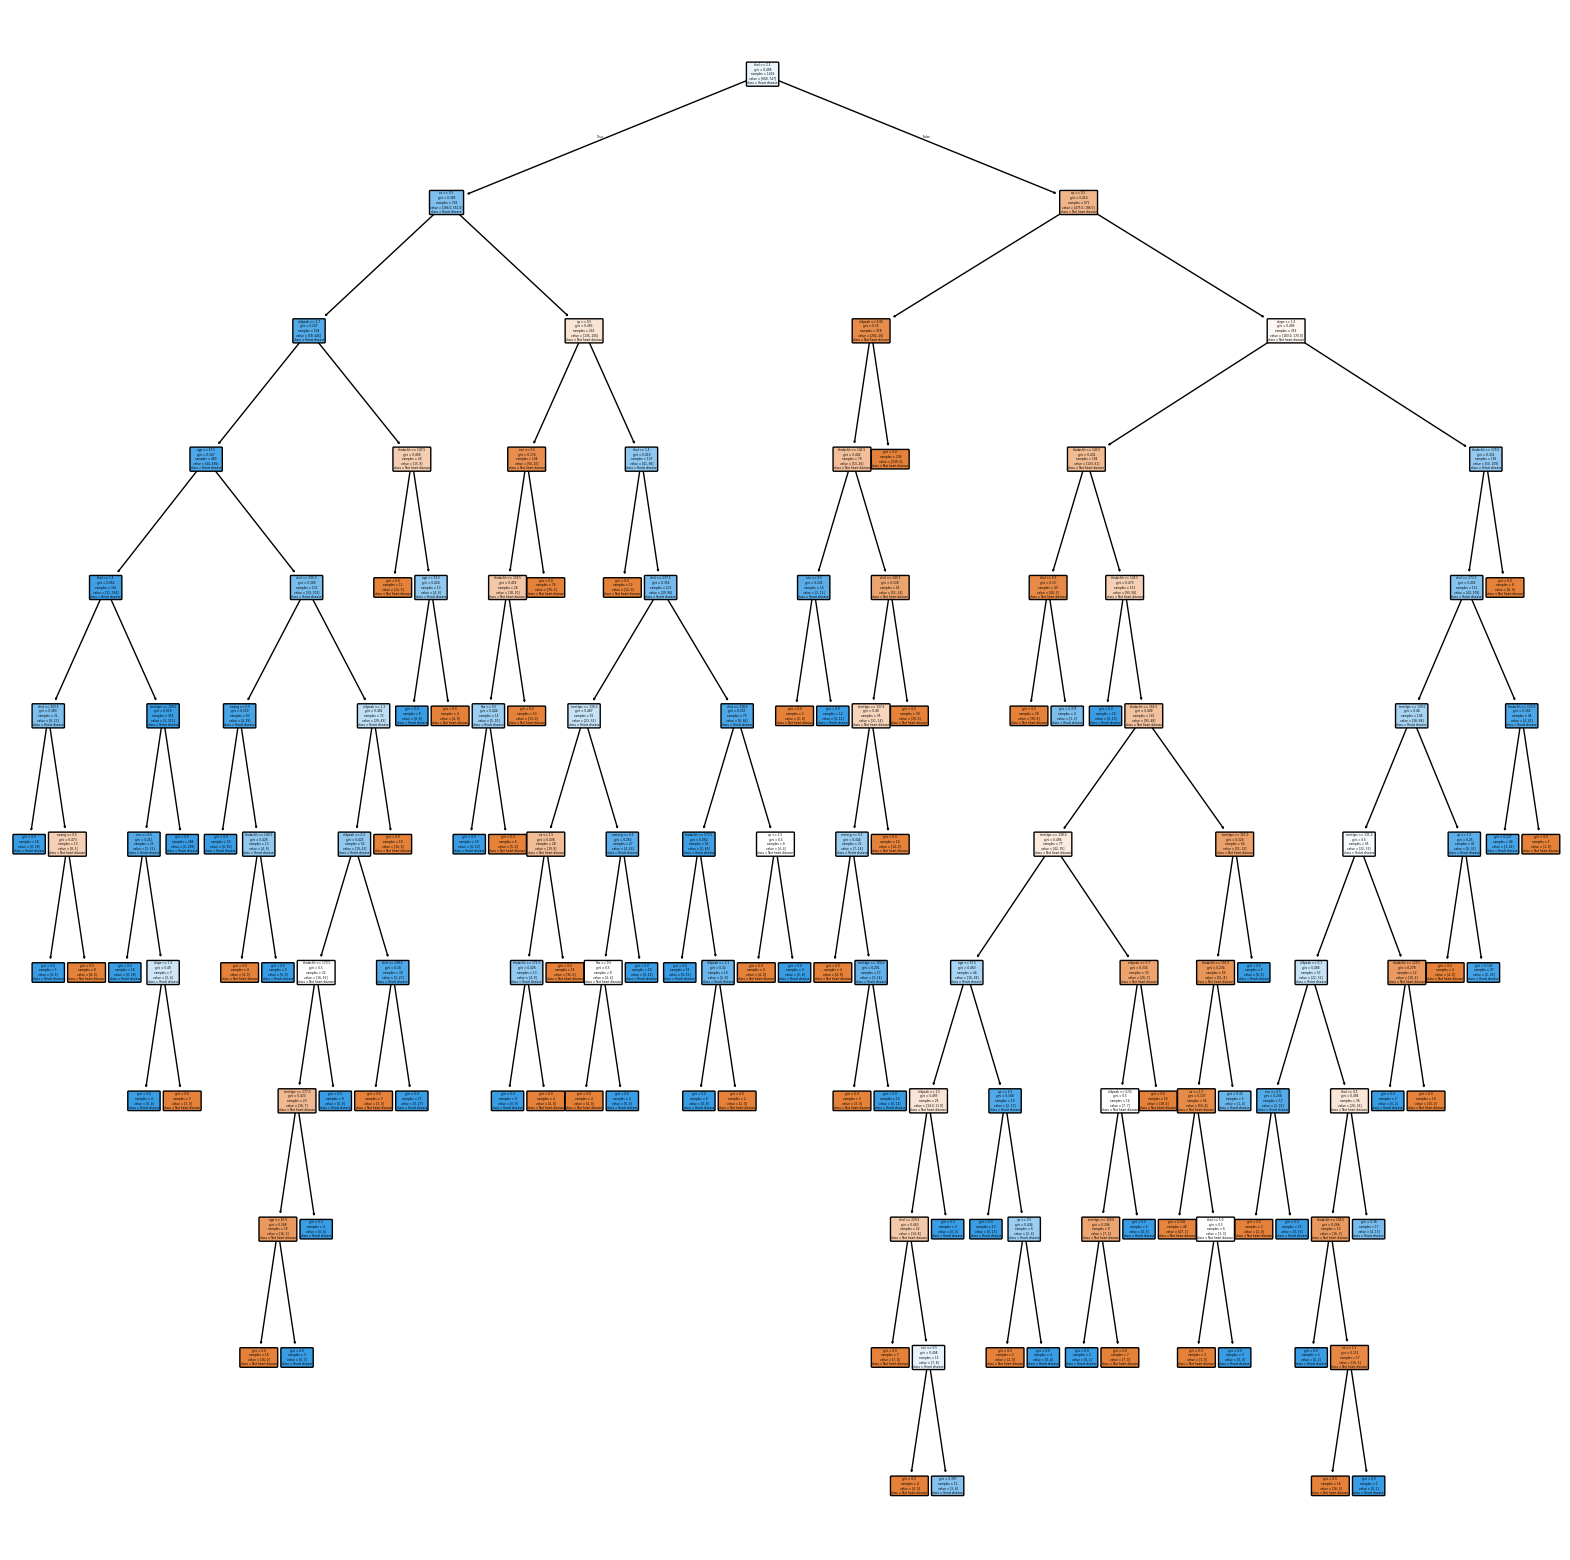

In [ ]:
plt.figure(figsize=(20,20))
features = df.columns
classes = ['Not heart disease','Heart disease']
tree.plot_tree(clf_,feature_names=features,class_names=classes,filled=True,rounded=True)
plt.savefig("decision_tree_plot.png", format="png", bbox_inches='tight')
plt.show()

# BAGGING

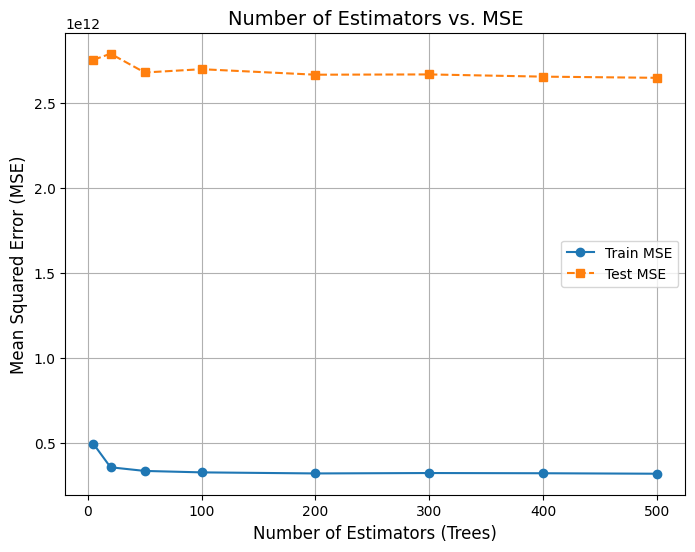

In [ ]:
mse_train_bagging = []
mse_test_bagging = []

# List of different numbers of estimators (trees)
estimators = [ 5  , 20 , 50 ,100, 200,300,400,500]

# Define base estimator (decision tree regressor)
base_tree = DTR(max_depth=16, random_state=42)

# Loop through different numbers of estimators
for estimator in estimators:
    bagging_regressor = BaggingRegressor(estimator=base_tree, n_estimators=estimator, random_state=42)
    bagging_regressor.fit(X_train, y_train)

    # Predictions
    y_train_pred = bagging_regressor.predict(X_train)
    y_test_pred = bagging_regressor.predict(X_test)

    # Compute MSE for train and test sets
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    # Append MSE values
    mse_train_bagging.append(train_mse)
    mse_test_bagging.append(test_mse)

# Plotting the MSE vs number of estimators
plt.figure(figsize=(8, 6))
plt.plot(estimators, mse_train_bagging, marker='o', label='Train MSE', linestyle='-')
plt.plot(estimators, mse_test_bagging, marker='s', label='Test MSE', linestyle='--')

# Adding labels, title, and legend
plt.xlabel('Number of Estimators (Trees)', fontsize=12)
plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
plt.title('Number of Estimators vs. MSE', fontsize=14)
plt.legend()
plt.grid(True)

# Optional: Adjust layout to avoid clipping of labels

# Show the plot
plt.show()

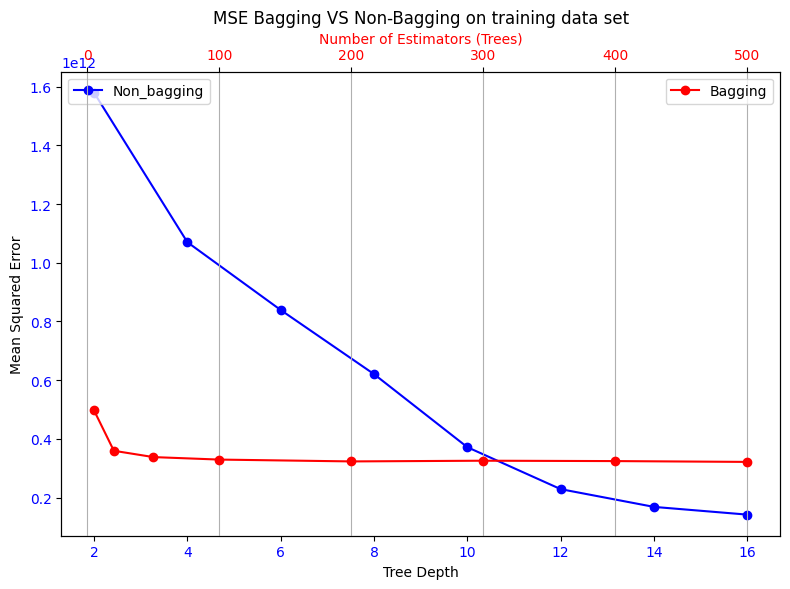

In [ ]:
# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot the first dataset (using the first x-axis)
ax1.plot(depths, mse_train,color = 'b',  marker='o', label='Non_bagging', linestyle='-')
ax1.set_xlabel('Tree Depth')  # Label for the first x-axis
ax1.set_ylabel('Mean Squared Error')   # Label for the shared y-axis
ax1.tick_params(axis='x', labelcolor='b')
ax1.tick_params(axis='y', labelcolor='b')


# Create a second x-axis
ax2 = ax1.twiny()

# Plot the second dataset (using the second x-axis)
ax2.plot(estimators, mse_train_bagging, color='r', marker='o', label='Bagging', linestyle='-')
ax2.set_xlabel('Number of Estimators (Trees)', color='r')  # Label for the second x-axis
ax2.tick_params(axis='x', labelcolor='r')

# Adding legends for both datasets
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Title and grid
plt.title('MSE Bagging VS Non-Bagging on training data set')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

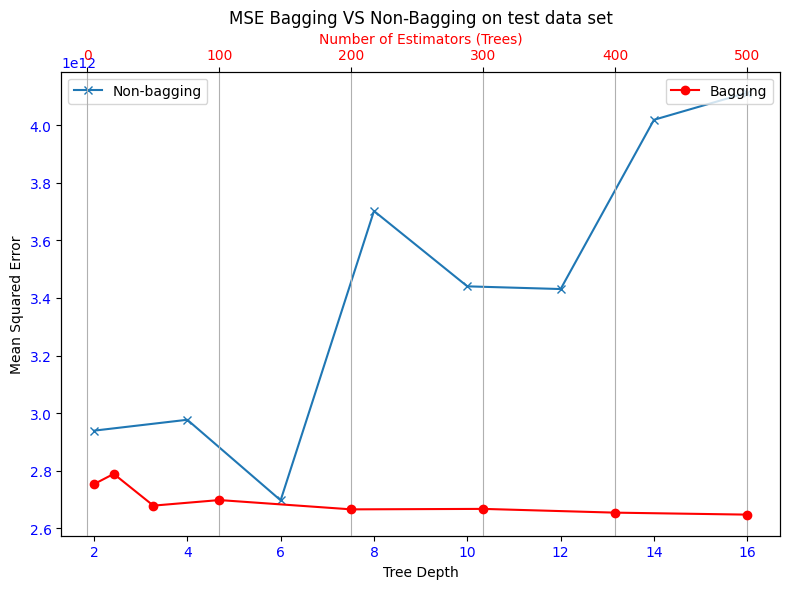

In [ ]:
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot the first dataset (using the first x-axis)
ax1.plot(depths, mse_test, marker='x', label='Non-bagging', linestyle='-')
ax1.set_xlabel('Tree Depth')  # Label for the first x-axis
ax1.set_ylabel('Mean Squared Error')   # Label for the shared y-axis
ax1.tick_params(axis='x', labelcolor='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second x-axis
ax2 = ax1.twiny()

# Plot the second dataset (using the second x-axis)
ax2.plot(estimators, mse_test_bagging, color='r', marker='o', label='Bagging', linestyle='-')
ax2.set_xlabel('Number of Estimators (Trees)', color='r')  # Label for the second x-axis
ax2.tick_params(axis='x', labelcolor='r')

# Adding legends for both datasets
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Title and grid
plt.title('MSE Bagging VS Non-Bagging on test data set')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
train_accuracy_scores = []
test_accuracy_scores = []

# List of different numbers of estimators (trees)
estimators = [5, 20, 50, 100, 200, 300, 400, 500]

# Define base estimator (decision tree classifier)
base_tree = DTC(random_state=42)

# Loop through different numbers of estimators
for estimator in estimators:
    # Create BaggingClassifier with the specified number of estimators
    bagging_classifier = BaggingClassifier(estimator=base_tree, n_estimators=estimator, random_state=42)

    # Fit the BaggingClassifier
    bagging_classifier.fit(x_train, y_train)

    # Compute accuracy on the training set
    y_train_pred = bagging_classifier.predict(x_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)

    # Compute accuracy on the test set
    y_test_pred = bagging_classifier.predict(x_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Append results to lists
    train_accuracy_scores.append(train_accuracy)
    test_accuracy_scores.append(test_accuracy)



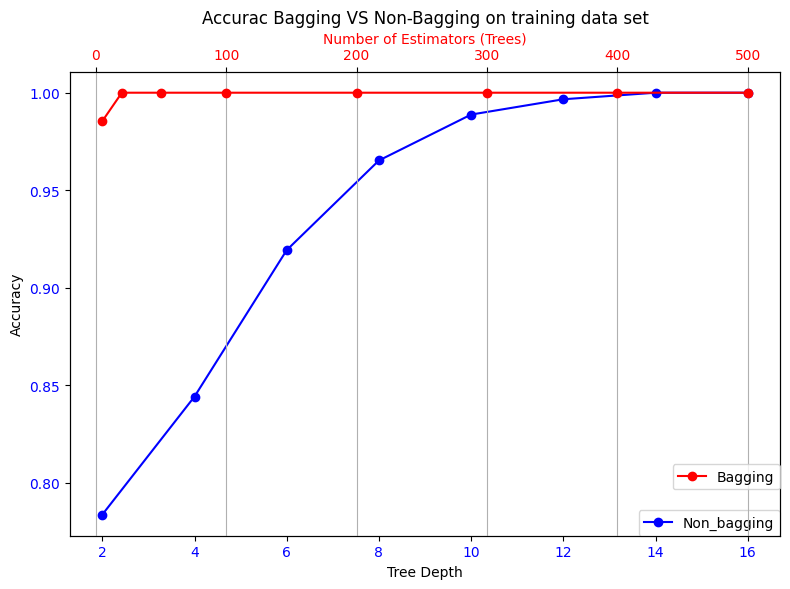

In [ ]:
depths= [2,4,6,8,10,12,14,16]
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot the first dataset (using the first x-axis)
ax1.plot(depths, accuracy_train,color = 'b',  marker='o', label='Non_bagging', linestyle='-')
ax1.set_xlabel('Tree Depth')  # Label for the first x-axis
ax1.set_ylabel('Accuracy')   # Label for the shared y-axis
ax1.tick_params(axis='x', labelcolor='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second x-axis
ax2 = ax1.twiny()

# Plot the second dataset (using the second x-axis)
ax2.plot(estimators, train_accuracy_scores, color='r', marker='o', label='Bagging', linestyle='-')
ax2.set_xlabel('Number of Estimators (Trees)', color='r')  # Label for the second x-axis
ax2.tick_params(axis='x', labelcolor='r')

# Adding legends for both datasets
ax1.legend(loc='lower right', bbox_to_anchor=(1, 0), borderaxespad=0.)
ax2.legend(loc='lower right', bbox_to_anchor=(1, 0.1), borderaxespad=0.)

# Title and grid
plt.title('Accurac Bagging VS Non-Bagging on training data set')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()



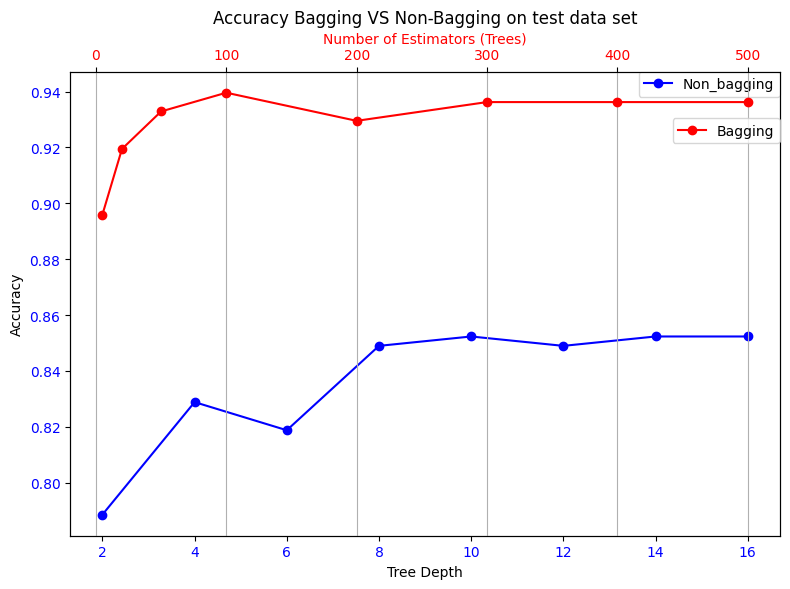

In [ ]:
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot the first dataset (using the first x-axis)
ax1.plot(depths, accuracy_test,color = 'b',  marker='o', label='Non_bagging', linestyle='-')
ax1.set_xlabel('Tree Depth')  # Label for the first x-axis
ax1.set_ylabel('Accuracy')   # Label for the shared y-axis
ax1.tick_params(axis='x', labelcolor='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second x-axis
ax2 = ax1.twiny()

# Plot the second dataset (using the second x-axis)
ax2.plot(estimators, test_accuracy_scores, color='r', marker='o', label='Bagging', linestyle='-')
ax2.set_xlabel('Number of Estimators (Trees)', color='r')  # Label for the second x-axis
ax2.tick_params(axis='x', labelcolor='r')

# Adding legends for both datasets
ax1.legend(loc='upper right', bbox_to_anchor=(1, 1), borderaxespad=0.)
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.9), borderaxespad=0.)

# Title and grid
plt.title('Accuracy Bagging VS Non-Bagging on test data set')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()



# RANDOM FOREST


In [ ]:
rf = RandomForestClassifier(n_estimators=100, max_depth=3)
rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=3)

In [ ]:
y_pred = rf.predict(x_test)

In [ ]:
#evaluate
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8557046979865772


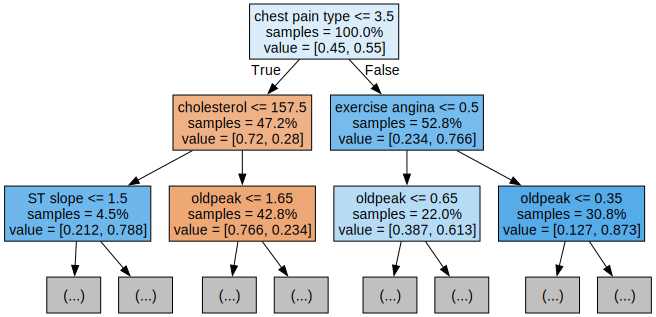

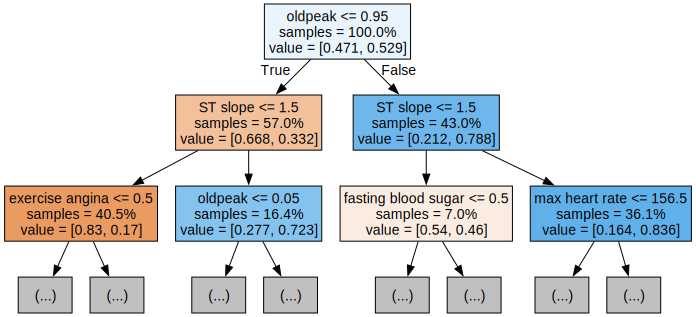

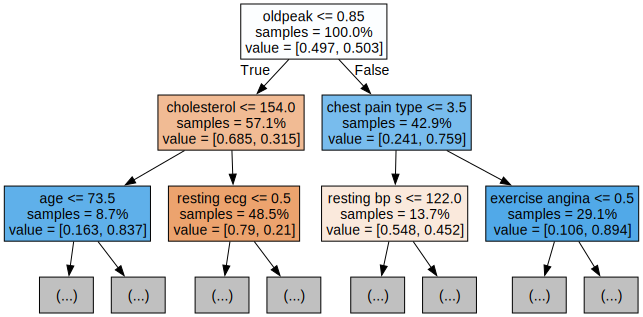

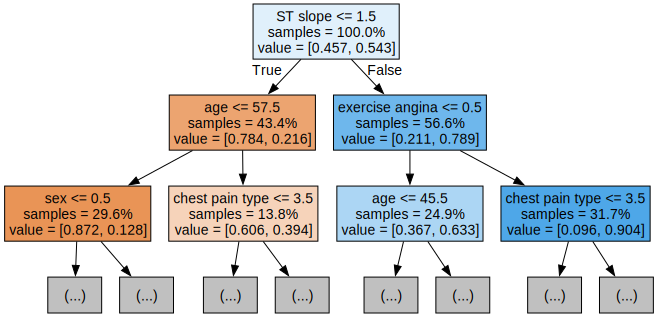

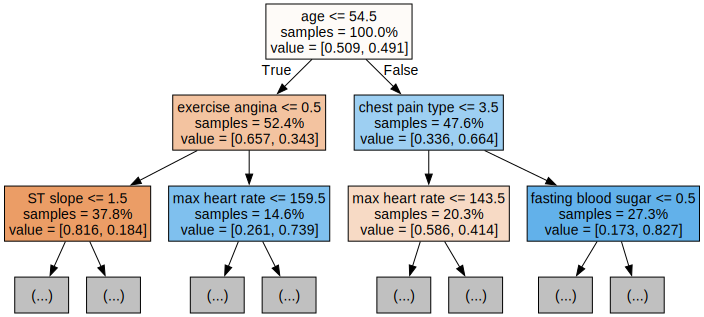

In [ ]:
# Export the first five decision trees from the forest
for i in range(5):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=x_train.columns,
                               filled=True,
                               max_depth=2,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)


Feature ranking:
1. ST slope (0.292585)
2. chest pain type (0.274404)
3. exercise angina (0.113056)
4. oldpeak (0.101899)
5. max heart rate (0.064869)
6. cholesterol (0.056416)
7. age (0.037563)
8. sex (0.034554)
9. resting bp s (0.011482)
10. fasting blood sugar (0.010634)
11. resting ecg (0.002540)


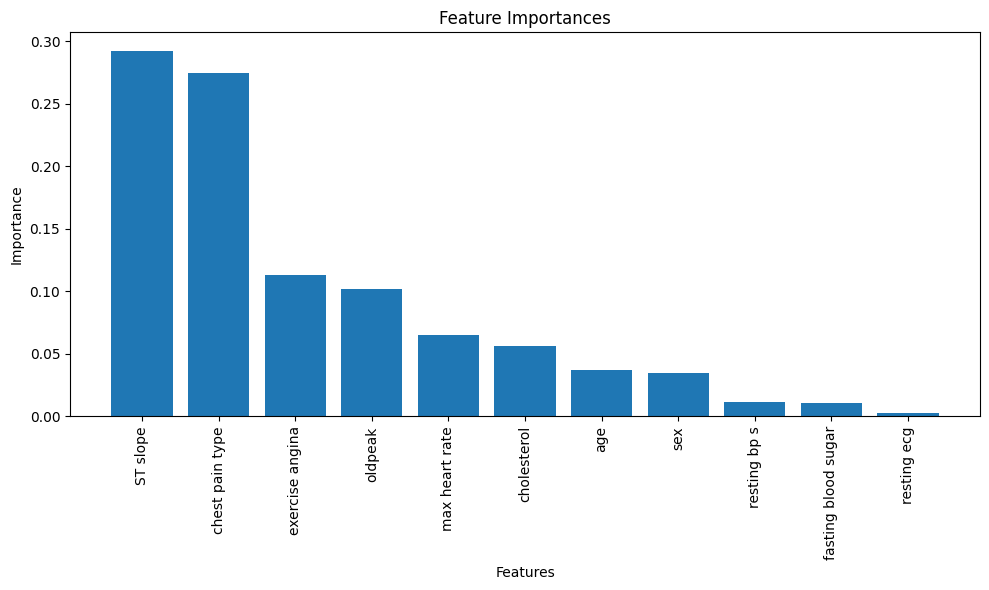

In [ ]:
importances = rf.feature_importances_
feature_names = X.columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("\nFeature ranking:")
for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

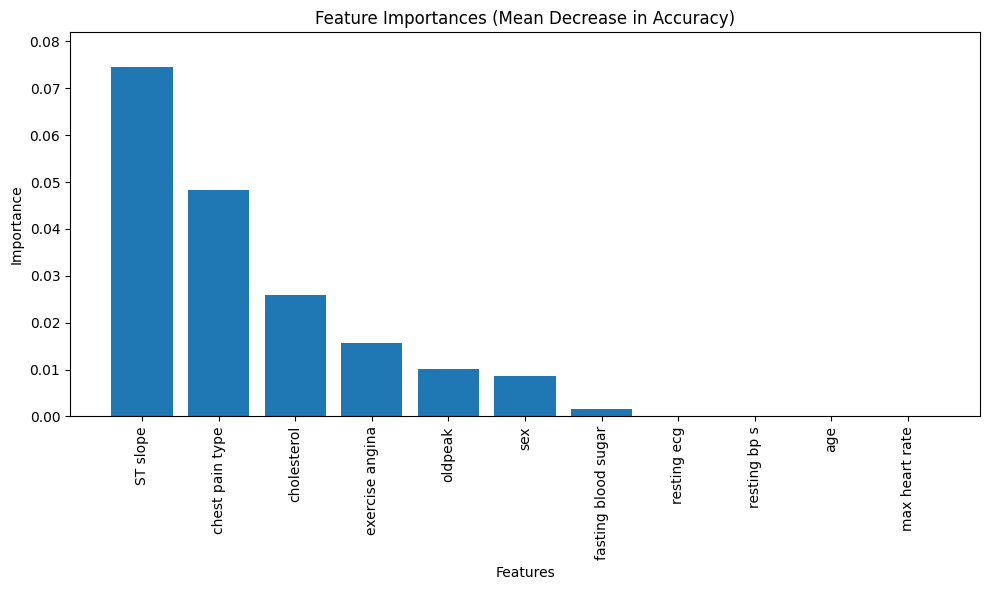


Feature ranking (Mean Decrease in Accuracy):
1. ST slope (0.074497)
2. chest pain type (0.048322)
3. cholesterol (0.025839)
4. exercise angina (0.015772)
5. oldpeak (0.010067)
6. sex (0.008725)
7. fasting blood sugar (0.001678)
8. resting ecg (0.000000)
9. resting bp s (-0.001007)
10. age (-0.004027)
11. max heart rate (-0.008725)

Feature ranking (Mean Decrease in Gini):
1. ST slope (0.292585)
2. chest pain type (0.274404)
3. exercise angina (0.113056)
4. oldpeak (0.101899)
5. max heart rate (0.064869)
6. cholesterol (0.056416)
7. age (0.037563)
8. sex (0.034554)
9. resting bp s (0.011482)
10. fasting blood sugar (0.010634)
11. resting ecg (0.002540)


In [ ]:
# Calculate Mean Decrease in Accuracy
result = permutation_importance(rf, x_test, y_test, n_repeats=10, random_state=42)
mda_importances = result.importances_mean

# Get Mean Decrease in Gini
mdg_importances = rf.feature_importances_

# Get feature names
feature_names = X.columns

# Function to plot importances
def plot_importances(importances, title):
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.ylim(0, max(importances) * 1.1)  # Start from 0 and add some padding above
    plt.tight_layout()
    plt.show()

# Plot Mean Decrease in Accuracy
plot_importances(mda_importances, "Feature Importances (Mean Decrease in Accuracy)")

# Plot Mean Decrease in Gini
plot_importances(mdg_importances, "Feature Importances (Mean Decrease in Gini)")

# Print feature rankings
print("\nFeature ranking (Mean Decrease in Accuracy):")
for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, feature_names[np.argsort(mda_importances)[::-1][f]], mda_importances[np.argsort(mda_importances)[::-1][f]]))

print("\nFeature ranking (Mean Decrease in Gini):")
for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, feature_names[np.argsort(mdg_importances)[::-1][f]], mdg_importances[np.argsort(mdg_importances)[::-1][f]]))

# BOOSTING - ADABOOST

In [ ]:
X = df.drop(['target'],axis=1)
y = df['target']
y=y*2-1
y=y.to_numpy()
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

def calculate_error(y, y_pred, w):
     return (sum(w * (np.not_equal(y, y_pred)).astype(int)))/sum(w)

def calculate_alpha(error):
    return np.log((1-error)/error)/2

def update_weights(w, alpha, y, y_pred):
    return w*np.exp(alpha*(np.not_equal(y,y_pred)).astype(int))


class AdaBoost:

    def __init__(self):
        self.alphas = []
        self.G_M = []
        self.training_errors = []

    def fit(self, X, y, M = 100):

        self.alphas = []
        self.training_errors = []
        self.M = M

        for m in range(0, M):

            if m == 0:
                w=np.ones(len(y))*1/len(y)


            else:
                w=update_weights(w,alpha_m,y,y_pred)
            G_m=DecisionTreeClassifier(max_depth=1)
            G_m.fit(X,y,w)

            y_pred=G_m.predict(X)
            self.G_M.append(G_m)
            error_m=calculate_error(y,y_pred,w)
            self.training_errors.append(error_m)
            alpha_m=calculate_alpha(error_m)
            self.alphas.append(alpha_m)

    def predict(self, X):

        weak_preds = pd.DataFrame(index = range(len(X)), columns = range(self.M))

        for m in range(self.M):
            y_pred_m = self.G_M[m].predict(X) * self.alphas[m]
            weak_preds[weak_preds.columns[m]] = y_pred_m

        y_pred = (1 * np.sign(weak_preds.T.sum())).astype(int)

        return y_pred

In [ ]:
model=AdaBoost()
model.fit(x_train,y_train,200)
y_pred=model.predict(x_test)
import sklearn.metrics as metrics

accuracy=metrics.accuracy_score(y_test, y_pred)
print(accuracy)




0.8907563025210085


In [ ]:
from sklearn.model_selection import train_test_split

def error_rate(y_true, y_pred):
    return np.mean(y_pred != y_true)

def evaluate_model_custom_adaboost(X_train, y_train, X_test, y_test, n_estimators, step):
    error_train, error_test = [], []
    for i in range(1, n_estimators + 1, step):
        model = AdaBoost()
        model.fit(X_train, y_train, M=i)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        error_train.append(error_rate(y_train, y_train_pred))
        error_test.append(error_rate(y_test, y_test_pred))

    return error_train, error_test


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

n_estimators = 200
step = 5
error_train, error_test = evaluate_model_custom_adaboost(X_train, y_train, X_test, y_test, n_estimators, step)

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_estimators + 1, step), error_train, label='Training Error Rate')
plt.plot(range(1, n_estimators + 1, step), error_test, label='Test Error Rate')
plt.xlabel('Number of Estimators')
plt.ylabel('Error Rate')
plt.title('Error Rate vs Number of Estimators in Custom AdaBoost')
plt.legend()
plt.grid(True)
plt.show()
